In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.constants import speed_of_light, elementary_charge, electron_mass, hbar as hbar_SI
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

In [2]:
me_SI = electron_mass
e_SI = elementary_charge
c_SI = speed_of_light

meV = e_SI * 1e-3
nm = 1e-9
ps = 1e-12

c = c_SI * ps / nm
hbar = hbar_SI / (meV * ps)
m = me_SI * c_SI ** 2 / meV / c ** 2

In [3]:
x_min, x_max = -50, 150
t_min, t_max = 0, 125
Nx, Nt = 10000, 10000

In [4]:
x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

dx = x_values[1] - x_values[0]
dt = t_values[1] - t_values[0]

In [5]:
print(f"dx = {dx}")
print(f"dt = {dt}")

dx = 0.020002000200022962
dt = 0.0125012501250125


In [6]:
m = m * 0.98 
omega = 1 / hbar												# from matlab reference pdf in box
alpha_ent_barr = 0.4900									# from 2019Yamahata paper			#		(meV / V)
alpha_ent_exit_barr = 0.0370						# paper												#   (meV / V)
alpha_exit_barr = 0.4800								# paper												#		(meV / V)
alpha_exit_ent_bar = 0.0520							# paper												#		(meV / V)
V_ent = -0.7000		#V										# paper
V_exit = -0.7000	#V										# paper
V_amp = 1.4150		#V?										# matlab reference
f = 4																		# matlab reference
x_ent = 0		#nm													# paper
x_exit = 100	#nm												# paper
U_scr = 1		#meV												# paper
L_ent = 100	#nm													# matlab reference
L_exit = 100 #nm												# matlab reference
L_scr = 1 #nm														# paper

In [7]:
def theta(arr):
  return np.array([1 if x > 0 else 0 for x in arr]) 

In [8]:
def V_ac(t):
  return V_amp * np.cos(2 * np.pi * f * t * 1e-3)

In [9]:
def U_ent(x, t):
  A = -alpha_ent_barr * (V_ent + V_ac(t))
  B = (alpha_ent_barr / alpha_ent_exit_barr) ** (-np.abs(x - x_ent) / np.abs(x_exit - x_ent))
  return A * B

In [10]:
def U_exit(x):
  A = -alpha_exit_barr * V_exit
  B = (alpha_exit_barr / alpha_exit_ent_bar) ** (-np.abs(x - x_exit) / np.abs(x_exit - x_ent))
  return A * B

In [11]:
def U_upper(x):
  A = U_scr * np.exp(-((x - x_ent) / L_scr) * theta(x - x_ent)) * np.exp(-((x_ent - L_ent - x) / L_scr) * theta(x_ent - L_ent - x))
  B = U_scr * np.exp(-((x - x_exit - L_exit) / L_scr) * theta(x - x_exit - L_exit)) * np.exp(-((x_exit - x) / L_scr) * theta(x_exit - x))
  return A + B

In [12]:
def U(x, t):
  return U_ent(x, t) + U_exit(x) + U_upper(x)

In [13]:
V = U(x_values, 0)

In [14]:
# for t in [0, 20, 40, 80, 125]:
#   V = U(x_values, t)
#   plt.plot(x_values, V)
# plt.title("Potential U(x, t) vs x")
# plt.xlabel("x")
# plt.ylabel("Potential U(x, t)")
# plt.show()

In [15]:
laplacian = sp.diags([1, -2, 1], offsets=[-1, 0, 1], shape=(Nx, Nx), format='csc') / dx ** 2
H_kinetic = - (hbar ** 2 / (2 * m)) * laplacian

In [16]:
H = H_kinetic + sp.diags(V, format="csc")

In [17]:
w, v = eigsh(H, k=4, which="SA")

In [18]:
w

array([-0.04849759,  0.1343596 ,  0.30363622,  0.51013525])

In [19]:
psi0_in = v[:, 0]

In [20]:
psi0_in /= np.sqrt(np.sum(np.abs(psi0_in) ** 2) * dx)

In [21]:
psi0 = psi0_in

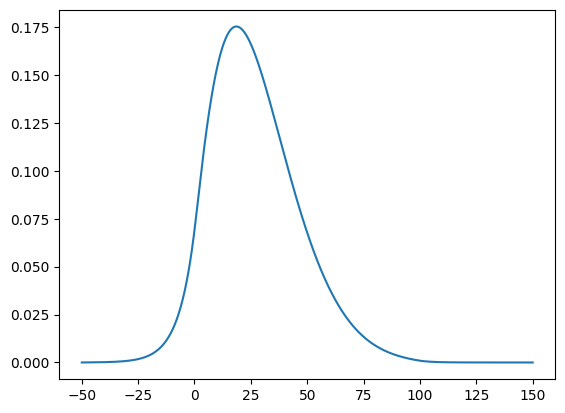

In [22]:
plt.plot(x_values, psi0)

In [23]:
psi_real = np.zeros((Nx, Nt))
psi_img = np.zeros((Nx, Nt))

psi_real[:, 0] = np.real(psi0)
psi_img[:, 0] = np.imag(psi0)

In [24]:
I = sp.eye(Nt, format="csc")

In [25]:
psi = psi0

In [26]:
for t_i in range(1, Nt):
	if t_i % 100 == 0:
		print(f"Step {t_i} / {Nt}")	

	# t_in = (t_min + (t_i - 1) * dt)
	U_arr = U(x_values, t_values[t_i])
	# U_min = np.argmin(U_arr)
	# qd_min = x_min + U_min * dx
	# V = 1 / 2 * m * omega ** 2 * (x_values - qd_min) ** 2
	H = H_kinetic + sp.diags(U_arr, 0, format='csc')
 
	

	A = I + 1j * dt / (2 * hbar) * H
	B = I - 1j * dt / (2 * hbar) * H

	psi = spla.spsolve(A, B @ psi)
	norm = np.sqrt(np.sum(np.abs(psi) ** 2) * dx)

	if norm > 0:
		psi /= norm
	else:
		print(f"Zero norm at step {t_i}")
		break

	psi_real[:, t_i] = np.real(psi)
	psi_img[:, t_i] = np.imag(psi)

Step 100 / 10000
Step 200 / 10000
Step 300 / 10000
Step 400 / 10000
Step 500 / 10000
Step 600 / 10000
Step 700 / 10000
Step 800 / 10000
Step 900 / 10000
Step 1000 / 10000
Step 1100 / 10000
Step 1200 / 10000
Step 1300 / 10000
Step 1400 / 10000
Step 1500 / 10000
Step 1600 / 10000
Step 1700 / 10000
Step 1800 / 10000
Step 1900 / 10000
Step 2000 / 10000
Step 2100 / 10000
Step 2200 / 10000
Step 2300 / 10000
Step 2400 / 10000
Step 2500 / 10000
Step 2600 / 10000
Step 2700 / 10000
Step 2800 / 10000
Step 2900 / 10000
Step 3000 / 10000
Step 3100 / 10000
Step 3200 / 10000
Step 3300 / 10000
Step 3400 / 10000
Step 3500 / 10000
Step 3600 / 10000
Step 3700 / 10000
Step 3800 / 10000
Step 3900 / 10000
Step 4000 / 10000
Step 4100 / 10000
Step 4200 / 10000
Step 4300 / 10000
Step 4400 / 10000
Step 4500 / 10000
Step 4600 / 10000
Step 4700 / 10000
Step 4800 / 10000
Step 4900 / 10000
Step 5000 / 10000
Step 5100 / 10000
Step 5200 / 10000
Step 5300 / 10000
Step 5400 / 10000
Step 5500 / 10000
Step 5600 / 10000
S

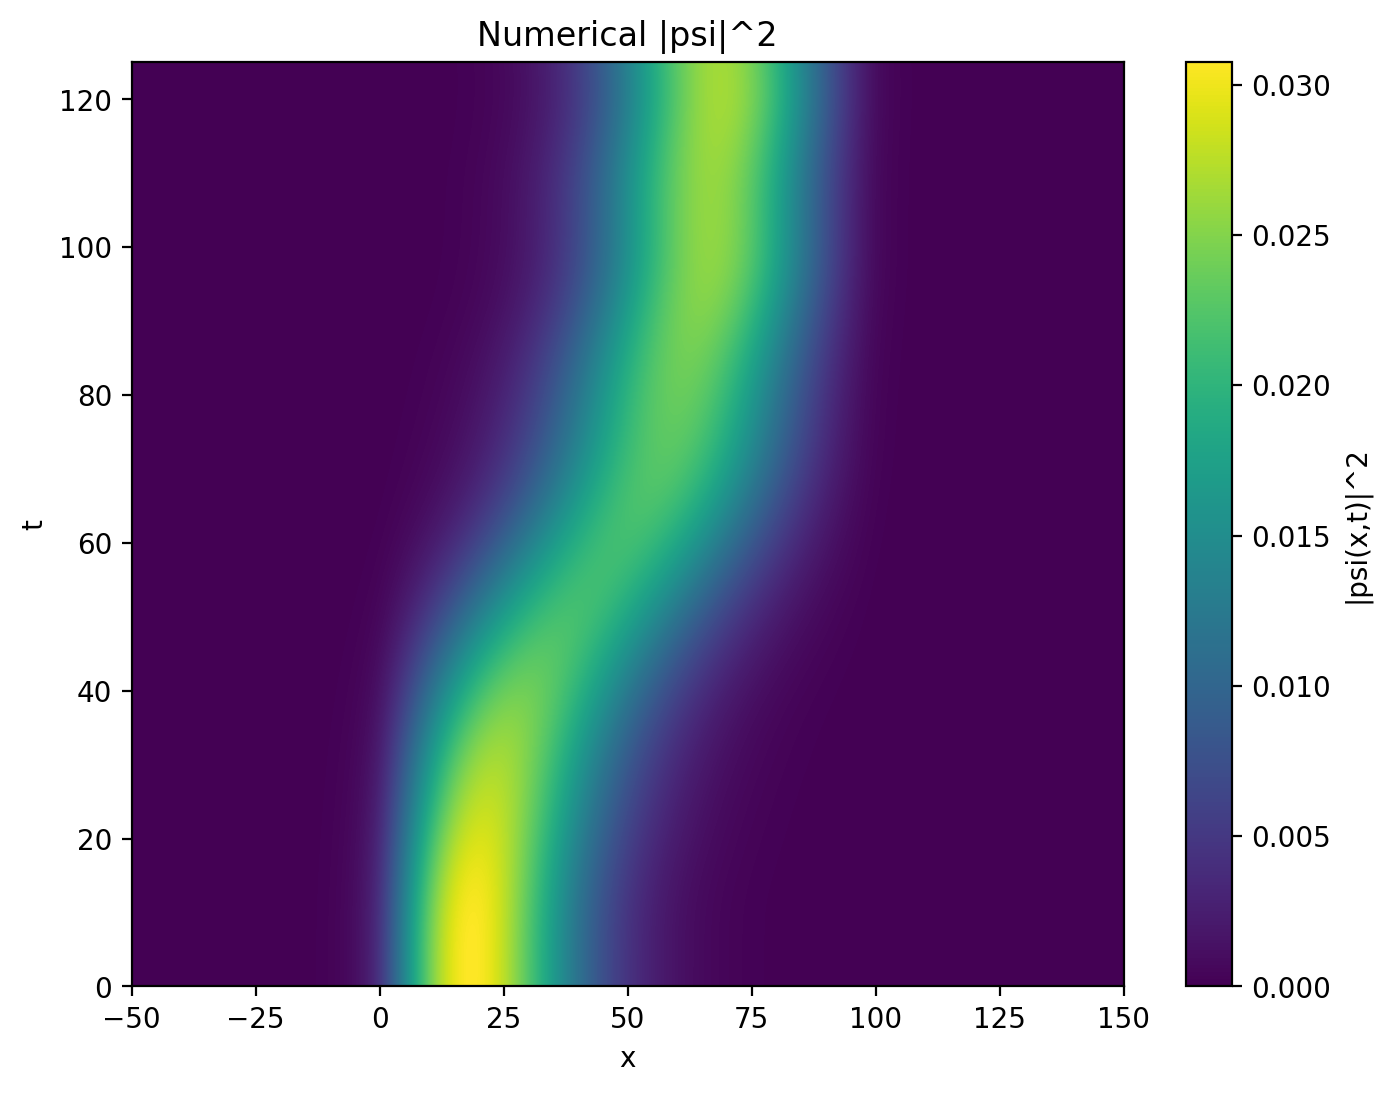

In [27]:
plt.figure(figsize=(8, 6), dpi=200)
psi_sq = psi_real ** 2 + psi_img ** 2

plt.pcolormesh(x_values, t_values, psi_sq.transpose(), shading="auto")
plt.colorbar(label='|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Numerical |psi|^2')
plt.show()

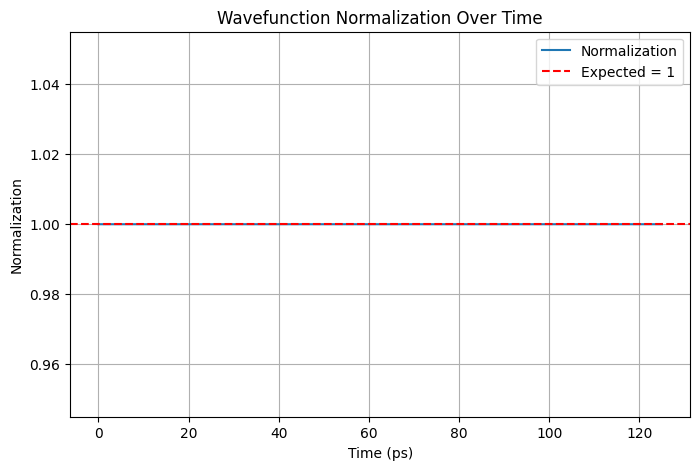

In [30]:
from scipy.integrate import simpson

norms = []

for i in range(10000):
    psi_sq = psi_real[:, i] ** 2 + psi_img[:, i] ** 2
    normalization = simpson(psi_sq, x=x_values)
    norms.append(np.round(normalization, 4))

plt.figure(figsize=(8,5))
plt.plot(t_values, norms, '-', label='Normalization')
plt.axhline(1.0, color='red', linestyle='--', label='Expected = 1')
plt.xlabel('Time (ps)')
plt.ylabel('Normalization')
plt.title('Wavefunction Normalization Over Time')
plt.legend()
plt.grid(True)
plt.show()

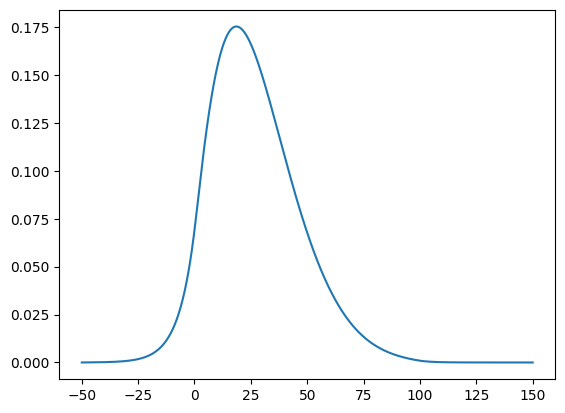

In [31]:
plt.plot(x_values, psi_real[:, 0])